Error minimizing using different values of angle per increment for each encoder

In [378]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import os
from tqdm import tqdm
sys.path.append(os.path.join(os.getcwd(), "..", ".."))
# from support.omniwheel_calculation_pd import *
from support.omniwheel_calculation import *
from datetime import datetime
from support.pd_support import *
from support.calculations_support import *
from support.ar_calculations import *
from numba import njit
import polars as pl
from support.imu_calculations import *

# %matplotlib widget
# import ipywidgets as widgets


In [379]:
_parent_folder = "omni_9dof_april_25_2023"
_folder_name = "sk33_sideways_slow_00"
_base_pth = os.path.dirname(os.getcwd())
_base_pth = os.path.dirname(_base_pth)
_base_pth = os.path.join(_base_pth,"recording_programs", "test_data", _parent_folder)
_base_pth

# C:\Users\CMC\Documents\openposelibs\pose\armbo\recording_programs\test_data\omni_9dof_april_20_2023\sk32_00_test_slow_00\imu01.csv

'c:\\Users\\CMC\\Documents\\openposelibs\\pose\\armbo\\recording_programs\\test_data\\omni_9dof_april_25_2023'

In [380]:
# _sk_df = pl.read_csv(os.path.join(_base_pth, _folder_name, "imu01.csv"))

# # convert unix epoc to datetime
# _sk_df = _sk_df.with_columns([pl.col("rust_time").apply(lambda x: datetime.fromtimestamp(x))])
# # _sk_df["rust_time"] = _sk_df["rust_time"].apply(lambda x: datetime.fromtimestamp(x))
# # rename columns rust_time to time
# _sk_df = _sk_df.rename({"rust_time": "time", "e_fr":"e_t"})
# _sk_df = _sk_df.to_pandas()


_sk_df = pd.read_csv(os.path.join(_base_pth, _folder_name, "imu01.csv"))
_sk_df["rust_time"] = _sk_df["rust_time"].apply(lambda x: datetime.fromtimestamp(x))
# rename columns
_sk_df.rename(columns={"rust_time": "time", "e_fr":"e_t"}, inplace=True)
_sk_df["e_t"] =  _sk_df["e_t"]
_sk_df["e_rr"] = _sk_df["e_rr"]
_sk_df["e_rl"] = _sk_df["e_rl"]

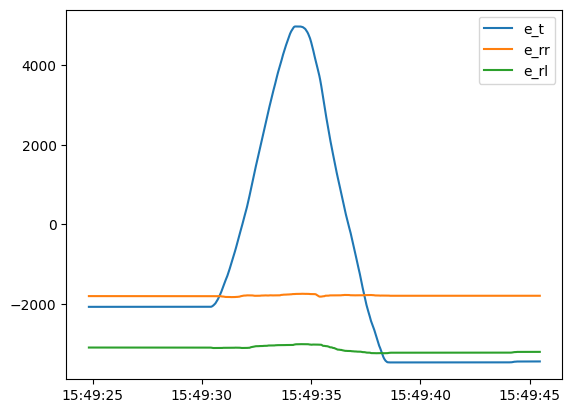

In [381]:
plt.plot(_sk_df["time"], _sk_df["e_t"], label="e_t")
plt.plot(_sk_df["time"], _sk_df["e_rr"], label="e_rr")
plt.plot(_sk_df["time"], _sk_df["e_rl"], label="e_rl")
plt.legend()


In [382]:
y = (19.7/2)/100 # meters
x = 9.25/100 # meters
radius = 5.5/200 # meters

df = _sk_df
df = set_zero(df)
df, ang_col = get_angular_velocity(df, ang_per_increment=0.15, del_t=0.01)
df, vel_col = get_directional_velocity(df, ang_col, radius=radius, x = x, y = y)
df, col_names = get_position(df)
df, _ang_name = get_orientation(df)

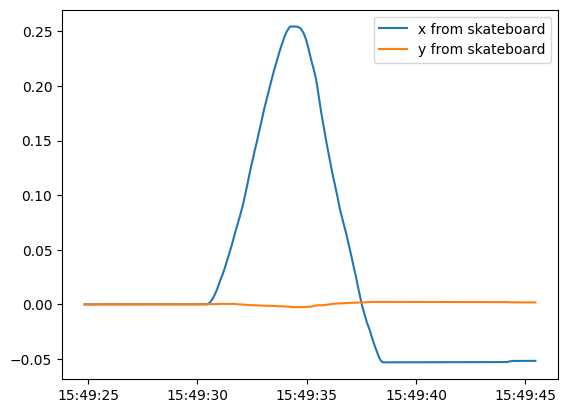

In [383]:
plt.plot(df["time"], df["x"], label="x from skateboard")
plt.plot(df["time"], df["y"], label="y from skateboard")
plt.legend()
# plt.plot(df["time"], df["theta"], label="e_rl")

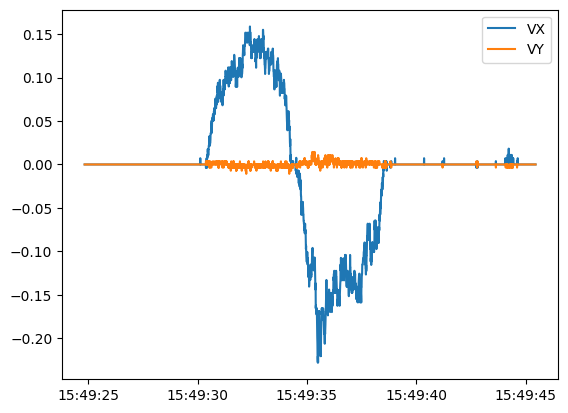

In [384]:
plt.plot(df["time"], df["vx"], label="VX")
plt.plot(df["time"], df["vy"], label="VY")
plt.legend()

In [385]:
sk_df = df[["time", "e_t", "e_rr", "e_rl"]]

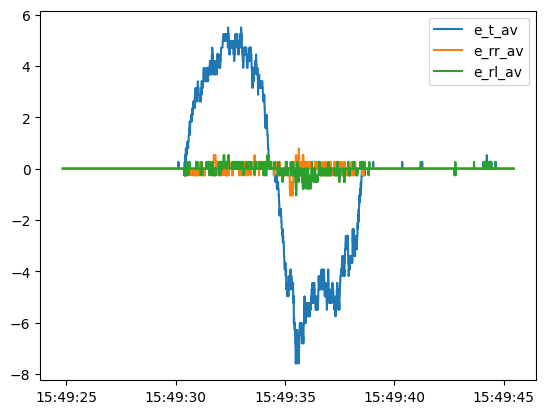

In [386]:
plt.plot(df["time"], df["e_t_av"], label="e_t_av")
plt.plot(df["time"], df["e_rr_av"], label="e_rr_av")
plt.plot(df["time"], df["e_rl_av"], label="e_rl_av")
plt.legend()

In [387]:
# type in marker details
_xm = get_marker_name(2)
_ym = get_marker_name(4)
_om = get_marker_name(1)

In [388]:
# mocap data
_mocap_df, st_time = read_rigid_body_csv(os.path.join(_base_pth, _folder_name.split("_")[0] ,_folder_name + ".csv"))
_mocap_df = add_datetime_col(_mocap_df, st_time, "seconds")

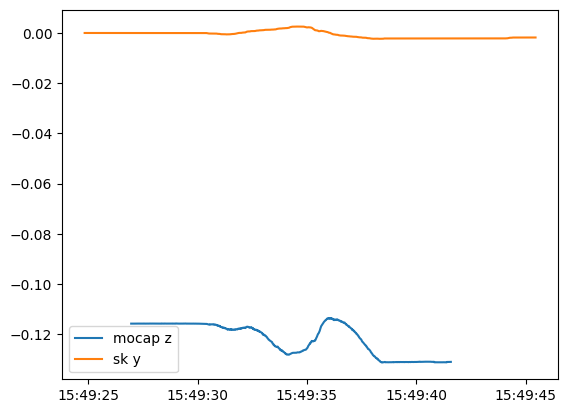

In [389]:
# plt.plot(_mocap_df.m2_x, label="x")
plt.plot(_mocap_df["time"], _mocap_df[_om["z"]], label="mocap z")
plt.plot(df["time"], -df["y"], label="sk y")

# plt.plot(df["w"], label="theta")
plt.legend()

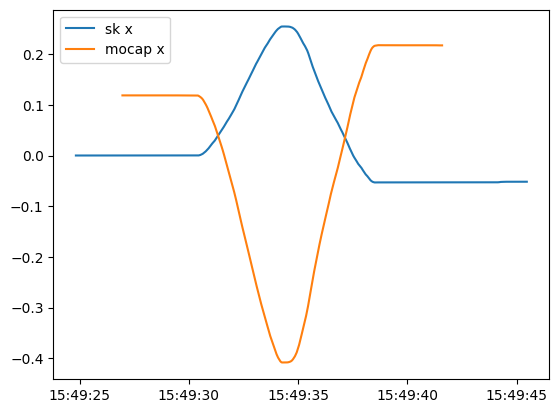

In [390]:
# plt.plot(_mocap_df.m2_x, label="x")
# plt.plot(_mocap_df["time"][:10000], _mocap_df[_om["x"]][:10000], label="mocap x")
# plt.plot(df["time"][:10000], -df["x"][:10000], label="vx")
plt.plot(df["time"], df["x"], label="sk x")
plt.plot(_mocap_df["time"], _mocap_df[_om["x"]], label="mocap x")


# plt.plot(df["w"], label="theta")
plt.legend()

In [391]:
"""
checking position
defining initial frame of reference
"""

xvec = [_mocap_df[_xm["x"]].iloc[0], _mocap_df[_xm["y"]].iloc[0], _mocap_df[_xm["z"]].iloc[0]]
xvec = np.array(xvec).reshape(3,1)

yvec = [_mocap_df[_ym["x"]].iloc[0], _mocap_df[_ym["y"]].iloc[0], _mocap_df[_ym["z"]].iloc[0]]
yvec = np.array(yvec).reshape(3,1)

org = [_mocap_df[_om["x"]].iloc[0], _mocap_df[_om["y"]].iloc[0], _mocap_df[_om["z"]].iloc[0]]
org = np.array(org).reshape(3,1)

v1 = xvec - org  # v1
v2 = yvec - org  # v2

vxnorm = v1 / np.linalg.norm(v1)

vycap = v2 - (vxnorm.T @ v2) * vxnorm
vynorm = vycap / np.linalg.norm(vycap)

vznorm = np.cross(vynorm.T[0], vxnorm.T[0]).reshape(3, 1)
rotMat = np.hstack((vxnorm, vynorm, vznorm)) # rotation matrix

In [392]:
@njit
def apply_rot_mat(mc_val, rotMat, org):
    return (rotMat.T @ (mc_val - org)).T[0]


In [393]:
# This cell is optimized to run faster using polars
_mc_df = _mocap_df[["time", _om["x"], _om["y"], _om["z"]]].copy()
_mc_df = _mc_df.rename(columns={_om["x"]: "x", _om["y"]: "y", _om["z"]: "z"})
# _mc_df = _mc_df.astype({"x": np.float64, "y": np.float64, "z": np.float64})

_mc_pl_df = pl.from_pandas(_mc_df)

my_dict = {"x":[],"y":[],"z":[]}

for i in tqdm(range(len(_mc_df))):
    _x, _y, _z = apply_rot_mat(_mc_pl_df[i, 1:].to_numpy().T, rotMat, org)
    my_dict["x"].append(_x)
    my_dict["y"].append(_y)
    my_dict["z"].append(_z)	

_mc_df["x"] = my_dict["x"]
_mc_df["y"] = my_dict["y"]
_mc_df["z"] = my_dict["z"]

100%|██████████| 1463/1463 [00:00<00:00, 2691.81it/s]


In [394]:
# This cell is optimized to run faster using polars

# calculate rotation matrix from xvec, zvec, org
_m_df = _mocap_df.copy()
_m_df = pl.from_pandas(_m_df)

_rotmat_i = []
for i in tqdm(range(len(_m_df))):
    
    _x_vec = _m_df[[_xm["x"], _xm["y"], _xm["z"]]][i, :].to_numpy().T
    _org = _m_df[[_om["x"], _om["y"], _om["z"]]][i, :].to_numpy().T
    _y_vec = _m_df[[_ym["x"], _ym["y"], _ym["z"]]][i, :].to_numpy().T

    _rotmat_i.append(calculate_rotmat_from_xyo(_x_vec, _y_vec, _org))
# calculating del rotmat for mc
_del_r = []
for i in tqdm(range(len(_rotmat_i))):
    _del_r.append(_rotmat_i[i].T@_rotmat_i[0])

# calculating angle for mc
_theta_x = []
_theta_y = []
_theta_z = []

for i in tqdm(_del_r):
    _theta_x.append(np.arctan2(i[2,1], i[2,2]))
    _theta_y.append(np.arctan2(-i[2,0], np.sqrt(i[2,1]**2 + i[2,2]**2)))
    _theta_z.append(np.arctan2(i[1,0], i[0,0]))
    
_theta_x = np.array(_theta_x)
_theta_y = np.array(_theta_y)
_theta_z = np.array(_theta_z)

# converting them to degrees
_theta_x = np.rad2deg(_theta_x)
_theta_y = np.rad2deg(_theta_y)
_theta_z = np.rad2deg(_theta_z)


100%|██████████| 1463/1463 [00:00<00:00, 100902.21it/s]


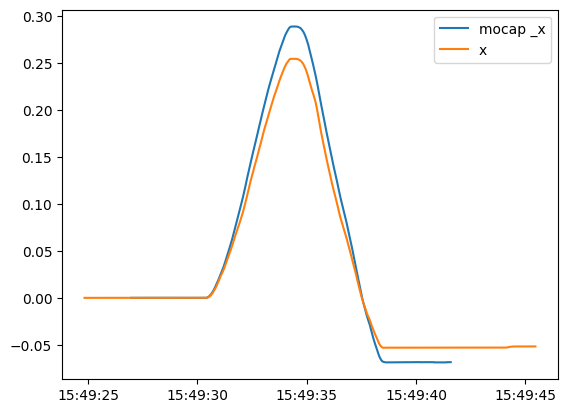

In [395]:
plt.plot(_m_df["time"], _mc_df["x"], label="mocap _x")
plt.plot(df["time"], df["x"], label="x")
plt.legend()

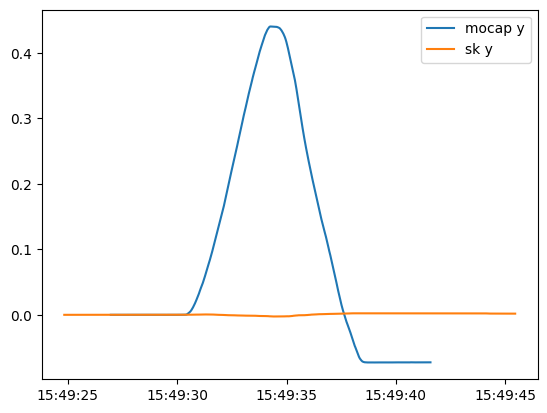

In [409]:
plt.plot(_m_df["time"], _mc_df["y"], label="mocap y")
plt.plot(df["time"], df["y"], label="sk y")
plt.legend()
# df.columns

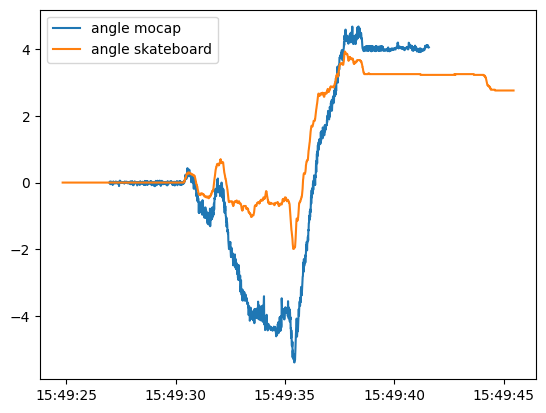

In [397]:
plt.plot(_m_df["time"], _theta_z, label="angle mocap")
plt.plot(df["time"], -np.rad2deg(df["theta"])*2.1, label="angle skateboard")
plt.legend()

In [398]:
"""
Transforming mocap data to robot frame of reference
Computing u1, u2, u3 from mocap data
"""
_mocap_rev = _mc_df[["time",'x', 'y']].copy()
_mocap_rev["theta"] = _theta_z
_mocap_rev["vx"] = -_mocap_rev["x"].diff() / 0.01
_mocap_rev["vy"] = _mocap_rev["y"].diff() / 0.01
_mocap_rev["wx"] = -_mocap_rev["theta"].diff() / 0.01
_mocap_rev = _mocap_rev.fillna(0)
# _mocap_rev[["wx", "vx", "vy"]]

In [399]:
y = (19.5/2)/100 # meters
x = 7.5/100 # meters
radius = 5.5/200 # meters

mat = np.array([[-y, 1, 0], [-x, 0, -1], [x, 0, -1]])

_uvec = {"u1":[], "u2":[], "u3":[]}
_mocap_rev = pl.from_pandas(_mocap_rev)
for i in tqdm(range(len(_mocap_rev))):
    _uvec["u1"].append(((1/radius)*(mat @ _mocap_rev[["wx", "vx", "vy"]][i].to_numpy().reshape(3,1))).T[0][0])
    _uvec["u2"].append(((1/radius)*(mat @ _mocap_rev[["wx", "vx", "vy"]][i].to_numpy().reshape(3,1))).T[0][1])
    _uvec["u3"].append(((1/radius)*(mat @ _mocap_rev[["wx", "vx", "vy"]][i].to_numpy().reshape(3,1))).T[0][2])


_mocap_rev = _mocap_rev.to_pandas()
_mocap_rev["u1"] = _uvec["u1"]
_mocap_rev["u2"] = _uvec["u2"]
_mocap_rev["u3"] = _uvec["u3"]

100%|██████████| 1463/1463 [00:00<00:00, 2442.41it/s]


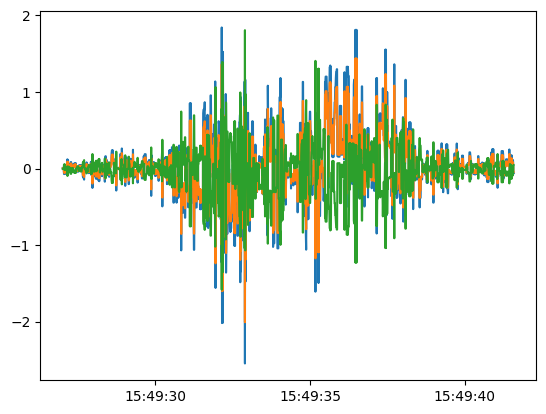

In [400]:
plt.plot(_mocap_rev["time"], _mocap_rev["u1"].rolling(5).median()/50, label="u1")
plt.plot(_mocap_rev["time"], _mocap_rev["u2"].rolling(5).median()/50, label="u2")
plt.plot(_mocap_rev["time"], _mocap_rev["u3"].rolling(5).median()/50, label="u3")

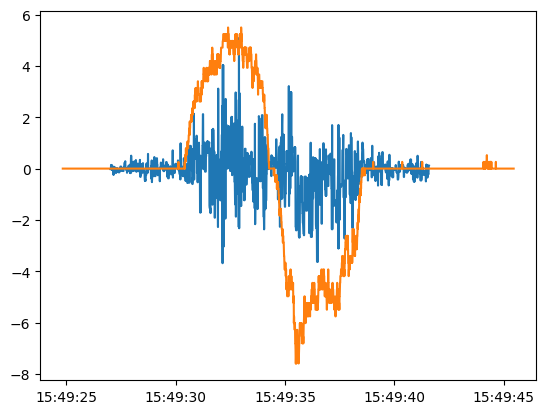

In [401]:
plt.plot(_mocap_rev["time"], -_mocap_rev["u1"].rolling(5).median()/25, label="u1")
plt.plot(df["time"], df["e_t_av"], label="e_t_av")


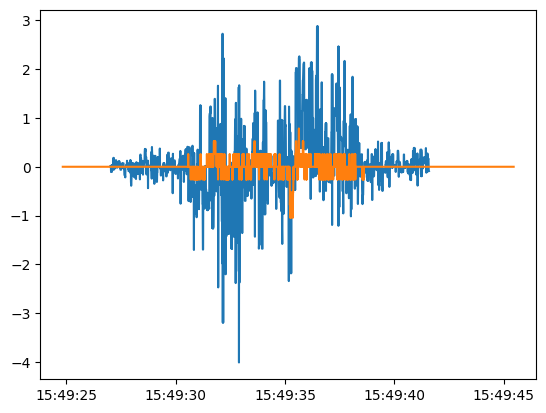

In [402]:
plt.plot(_mocap_rev["time"], _mocap_rev["u2"].rolling(5).median()/25, label="u1")
plt.plot(df["time"], df["e_rr_av"], label="e_t_av")


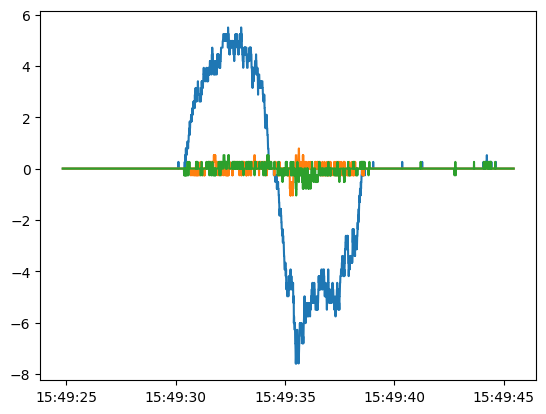

In [403]:
plt.plot(df["time"], df["e_t_av"], label="e_t_av")
plt.plot(df["time"], df["e_rr_av"], label="e_rr_av")
plt.plot(df["time"], df["e_rl_av"], label="e_rl_av")

In [404]:
# angular velocity to angular displacement
_mocap_rev["u1_angle"] = _mocap_rev["u1"].cumsum() *0.01*np.pi/180
_mocap_rev["u2_angle"] = _mocap_rev["u2"].cumsum() *0.01*np.pi/180
_mocap_rev["u3_angle"] = _mocap_rev["u3"].cumsum() *0.01*np.pi/180

In [405]:
# plt.plot(_mocap_rev["time"][:5000], _mocap_rev["u3_angle"][:5000], label="u1")
# plt.plot(_sk_df["time"][:5000], _sk_df["e_rl_av"][:5000], label="sk e_t_av")
# plt.legend()

In [406]:
_sk_rev = _sk_df[["time", "e_t", "e_rr", "e_rl"]].copy()
_sk_rev["e_t_angle"] = _sk_rev["e_t"]* 0.09 * np.pi/180
_sk_rev["e_rr_angle"] = _sk_rev["e_rr"]* 0.09 * np.pi/180
_sk_rev["e_rl_angle"] = _sk_rev["e_rl"]* 0.09 * np.pi/180

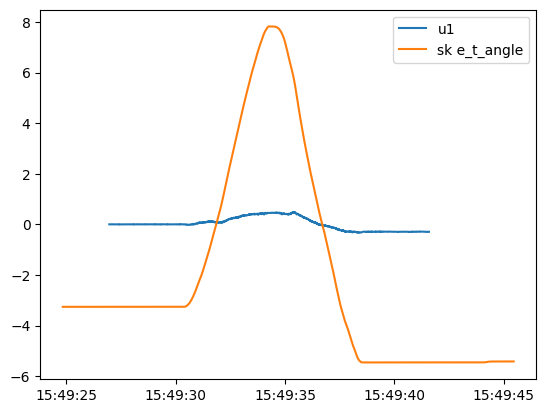

In [407]:
plt.plot(_mocap_rev["time"], -_mocap_rev["u1_angle"], label="u1")
plt.plot(_sk_rev["time"], _sk_rev["e_t_angle"], label="sk e_t_angle")
plt.legend()

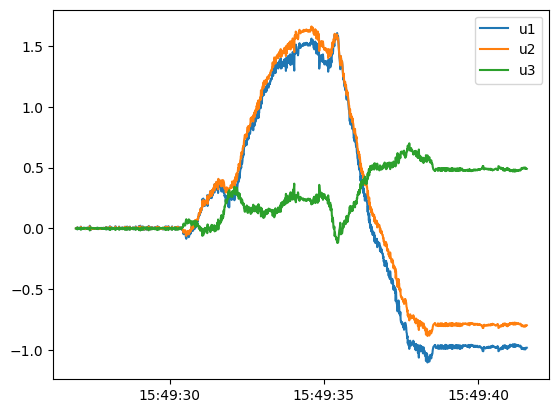

In [408]:
plt.plot(_mocap_rev["time"][:10000], -_mocap_rev["u1_angle"][:10000]/0.3, label="u1")
plt.plot(_mocap_rev["time"][:10000], -_mocap_rev["u2_angle"][:10000]/0.3, label="u2")
plt.plot(_mocap_rev["time"][:10000], -_mocap_rev["u3_angle"][:10000]/0.3, label="u3")

# plt.plot(_sk_rev["time"][:10000], _sk_rev["e_rr_angle"][:10000], label="sk e_t_angle")
plt.legend()